In [12]:
from utils.Auger.SD.Monitoring import Monit
from scipy.optimize import curve_fit
from utils.binaries import *
from utils import CONSTANTS
import os

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, t=None, version=None):
     
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC_bin_edges = np.array([4*k for k in range(100)] + [400 + 16*k for k in range(51)])
        case 3:
            ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])

    skip = 5
    _peak = np.argmax(counts[skip:100]) + skip
    _dip = np.argmax(np.diff(counts)) + 3
    start, stop = _dip + int(0.5 * (_peak - _dip)), _peak + int(0.5*(_peak - _dip))

    try:
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, ADC[_peak], counts[_peak]])

        file_loc = f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png"

        if not os.path.isfile(file_loc):
            os.makedirs(f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/", exist_ok=True)
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png')
            plt.close(fig)


        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError
        if mip.n > 300: raise ValueError
    except:
        return np.nan, np.nan

    return mip.n, mip.std_dev


version = 'v23'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, (wcd1, wcd2, wcd3) = monit('fTime', 136), monit('fPeak', 136).T
mask = [True if v != 0 else False for v in wcd3]

_, t_acq, t_gps, pmt, *histos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/out.txt', unpack=True)
histo_mask = np.where(np.sum(np.array(histos).T[:, :5], axis=1))[0]

t_muonbuffer, mf_wcd1, hz1, mf_wcd2, hz2, mf_wcd3, hz3, ssd, hz4 = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', unpack=True)

nan_mask = np.isnan(t_muonbuffer)
muonfill = lambda x: x[~nan_mask]
t_muonbuffer = muonfill(t_muonbuffer)
ssd = muonfill(ssd) / (2.64 * 10)
mf_wcd1 = muonfill(mf_wcd1)/10
mf_wcd2 = muonfill(mf_wcd2)/10
mf_wcd3 = muonfill(mf_wcd3)/10
t_muonbuffer += CONSTANTS.GPS_OFFSET

15:58:12 (  +35.4s) [INFO   ] -- received 1 file(s) as input
15:58:12 (  +122ms) [INFO   ] -- View monit keys with self.keys()
15:58:12 (    +4ms) [INFO   ] -- found 230 entries for key fTime and station #136
15:58:12 (    +7ms) [INFO   ] -- found 230 entries for key fPeak and station #136


(4.789772727272725, 156.91477272727272)

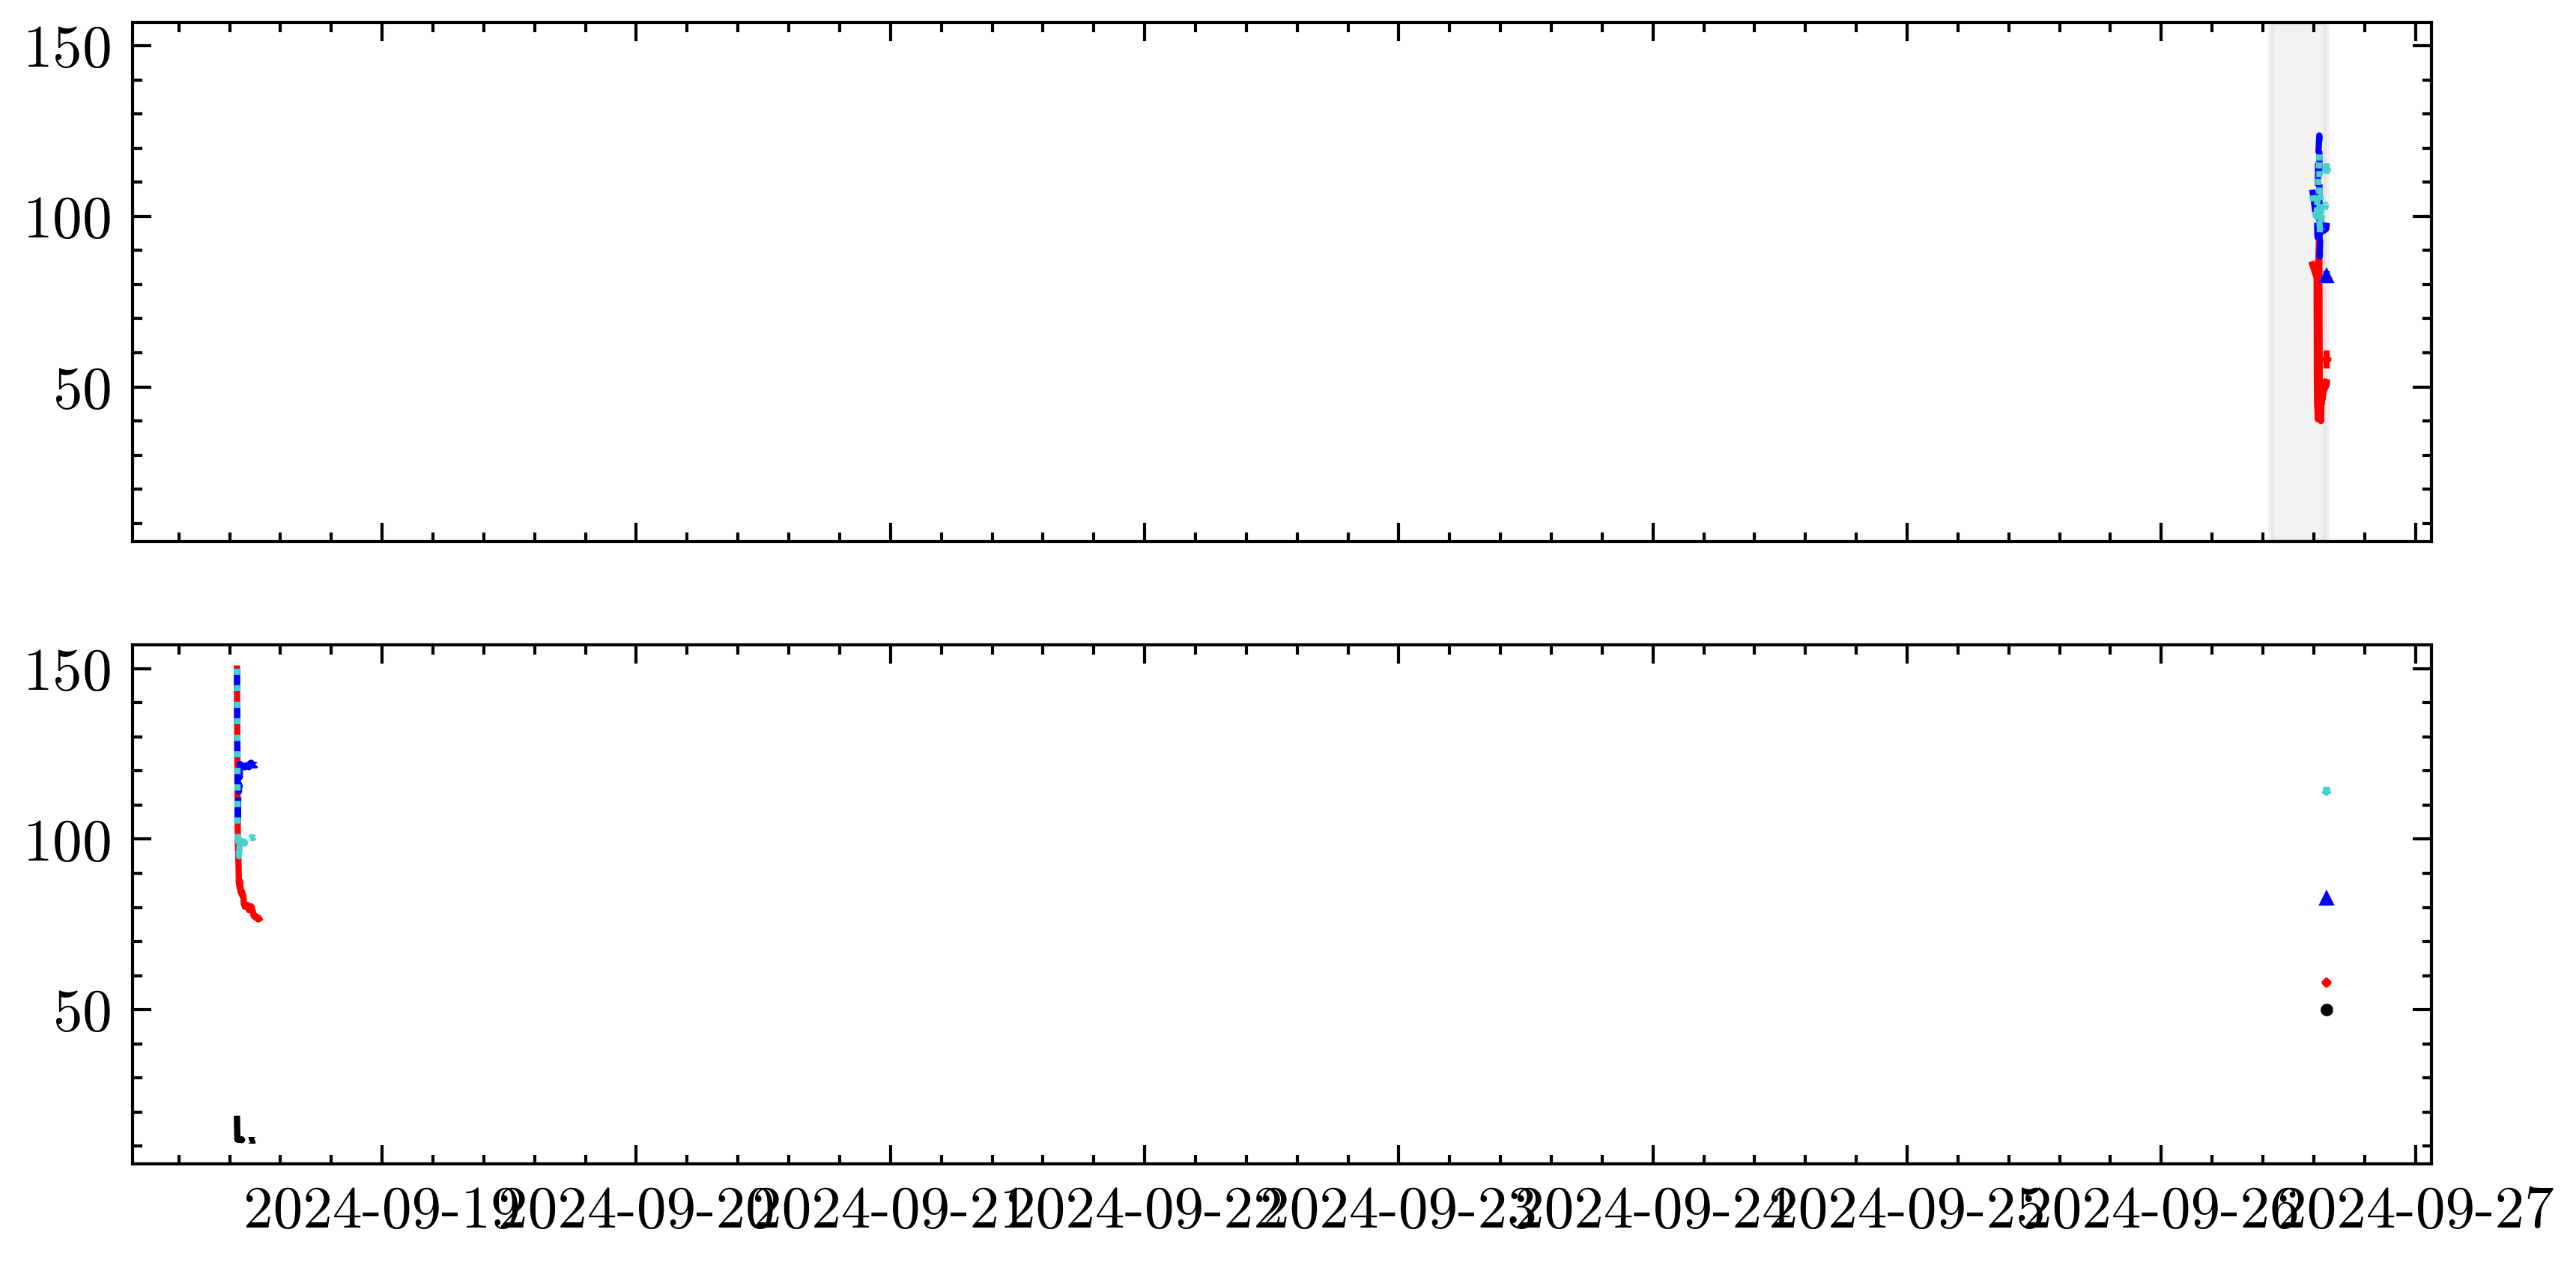

In [13]:
from utils.plotting import *

errorbar_kwargs = [
    {'marker' : 'x', 'c' : 'r'},
    {'marker' : '^', 'c' : 'b'},
    {'marker' : '*', 'c' : 'mediumturquoise'},
    {'marker' : 'o', 'c' : 'k'},
]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

ax1.plot(plot.to_datetime(t[mask]), wcd1[mask], c='r')
ax1.plot(plot.to_datetime(t[mask]), wcd2[mask], c='b')
ax1.plot(plot.to_datetime(t[mask]), wcd3[mask], c='mediumturquoise')

ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd1, c='r')
ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd2, c='blue')
ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd3, c='mediumturquoise')
ax2.plot(plot.to_datetime(t_muonbuffer), ssd, c='k')

for i, (tx, p, histo) in enumerate(zip(t_gps[histo_mask], pmt[histo_mask], np.array(histos).T[histo_mask])):

    mip, std_mip = make_histo_fit(histo, p, tx, version)
    # mip, std_mip = make_histo_fit(histo, p)
    if p != 3: ax1.errorbar(plot.to_datetime(tx), mip, std_mip, ms=1, **errorbar_kwargs[int(p)])
    ax2.errorbar(plot.to_datetime(tx), mip, 0, ms=1, **errorbar_kwargs[int(p)])


left, right = ax1.get_xlim()
bottom, top = ax1.get_ylim()

ax1.fill_between(plot.to_datetime(t), bottom, top, 
                 where=[a < t_muonbuffer[0] or a > t_muonbuffer[-1] for a in t], 
                 color='gray', alpha=0.1, label='V128R0B0P29')

ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)

# ax1.legend(title='Xb')
# ax2.legend(title='MuonFill')

In [3]:
print("asd")

asd


In [9]:
file_loc=f"/cr/data01/filip/plots/DaqIntegrationTest/v23/pmt0/{t_gps[0]}.png"
print(os.path.isfile(file_loc))

False


In [5]:
print(t_gps)

[1.7273649e+09 1.7273649e+09 1.7273649e+09 1.7273649e+09]


In [8]:
print(file_loc)

('/cr/data01/filip/plots/DaqIntegrationTest/v23/pmt0/1727364895.0.png',)
